In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [ ]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Natural Language Processing


## 1. Text Pre-processing

# 1.1 Loading the Dataset



In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bridge',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_b

We will be using the imdb reviews dataset as our dataset for the session today. This is a text classification dataset where each label can be 0 or 1, indicating a positive or negative review.

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJYEOD/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJYEOD/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEJYEOD/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data = train_data.shuffle(10)

In [ ]:
text_batch, label_batch = next(iter(train_data.batch(5)))
for i in range(5):

  print("Review: ", text_batch.numpy()[i])
  print("Label:", label_batch.numpy()[i])


Review:  b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.'
Label: 1
Review:  b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'
Label: 1
Review:  b'Okay, you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed,

# 1.2 Tokenization

Tokenization is when we split our text into chunks and assign each of them a unique numerical ID.

In [ ]:
word = "silent"
another_word = "listen"

In [ ]:
[ord(char) for char in word]

[115, 105, 108, 101, 110, 116]

In [ ]:
[ord(char) for char in another_word]

[108, 105, 115, 116, 101, 110]

![](https://miro.medium.com/v2/resize:fit:1400/1*CdjbU3J5BYuIi-4WbWnKng.png)

![](https://miro.medium.com/v2/resize:fit:1378/1*3CNBx4iZ1vmJCZgGUIC83A.png)

In [ ]:
raw_data = text_batch.numpy()

raw_data

array([b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.',
       b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.',
       b'Okay, you have:<br /><br />Penelope Keith as Miss Herringbone-Tweed, B.B.E. (Backbone of E

In [ ]:
plain_text = [i.decode("utf-8") for i in raw_data]

print(plain_text[0])

As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.


In [ ]:
word_tokenized = []

for i in range(len(plain_text)):
  word_tokenized.append(tf.keras.preprocessing.text.text_to_word_sequence(plain_text[i]))

word_tokenized[0]

['as',
 'others',
 'have',
 'mentioned',
 'all',
 'the',
 'women',
 'that',
 'go',
 'nude',
 'in',
 'this',
 'film',
 'are',
 'mostly',
 'absolutely',
 'gorgeous',
 'the',
 'plot',
 'very',
 'ably',
 'shows',
 'the',
 'hypocrisy',
 'of',
 'the',
 'female',
 'libido',
 'when',
 'men',
 'are',
 'around',
 'they',
 'want',
 'to',
 'be',
 'pursued',
 'but',
 'when',
 'no',
 'men',
 'are',
 'around',
 'they',
 'become',
 'the',
 'pursuers',
 'of',
 'a',
 '14',
 'year',
 'old',
 'boy',
 'and',
 'the',
 'boy',
 'becomes',
 'a',
 'man',
 'really',
 'fast',
 'we',
 'should',
 'all',
 'be',
 'so',
 'lucky',
 'at',
 'this',
 'age',
 'he',
 'then',
 'gets',
 'up',
 'the',
 'courage',
 'to',
 'pursue',
 'his',
 'true',
 'love']

In [ ]:
max_num_words = 10000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_num_words)

tokenizer.fit_on_texts(word_tokenized)

tokens = tokenizer.texts_to_sequences(word_tokenized)

print(tokens[0])

[8, 174, 14, 175, 25, 1, 90, 40, 91, 176, 9, 11, 15, 26, 177, 92, 178, 1, 49, 93, 179, 180, 1, 181, 5, 1, 94, 182, 20, 50, 26, 51, 10, 52, 6, 27, 183, 18, 20, 33, 50, 26, 51, 10, 184, 1, 185, 5, 3, 186, 187, 188, 34, 4, 1, 34, 189, 3, 95, 190, 191, 96, 192, 25, 27, 28, 193, 21, 11, 97, 35, 194, 195, 53, 1, 196, 6, 197, 41, 198, 98]


# 1.3 Vectorization


In [ ]:
# Convert the dataset from a gen into dataset format
text_batch, label_batch = next(iter(train_data.batch(128)))

text_dataset = tf.data.Dataset.from_tensor_slices(text_batch)

text_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_num_words,
 output_mode='int',
 output_sequence_length=10)

vectorize_layer.adapt(text_dataset.batch(64))

In [ ]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'of',
 'and',
 'a',
 'to',
 'is',
 'in',
 'this',
 'i',
 'it',
 'that',
 'br',
 'as',
 'with',
 'for',
 'was',
 'film',
 'you',
 'movie',
 'but',
 'are',
 'one',
 'have',
 'be',
 'on',
 'his',
 'not',
 'all',
 'they',
 'just',
 'an',
 'by',
 'from',
 'at',
 'so',
 'her',
 'who',
 'has',
 'its',
 'he',
 'if',
 'about',
 'what',
 'some',
 'or',
 'like',
 'no',
 'my',
 'when',
 'there',
 'their',
 'out',
 'she',
 'which',
 'will',
 'more',
 'good',
 'see',
 'first',
 'me',
 'would',
 'most',
 'them',
 'up',
 'had',
 'get',
 'well',
 'too',
 'other',
 'movies',
 'do',
 'even',
 'story',
 'people',
 'only',
 'into',
 'dont',
 'were',
 'very',
 'can',
 'really',
 'also',
 'way',
 'then',
 'seen',
 'any',
 'great',
 'been',
 'we',
 'many',
 'than',
 'how',
 'ever',
 'think',
 'these',
 'should',
 'time',
 'much',
 'make',
 'films',
 'actors',
 'could',
 'best',
 'while',
 'plot',
 'did',
 'after',
 'him',
 'say',
 'because',
 'three',
 'such',
 'still',
 'scenes',
 'ma

In [ ]:
demo_model = tf.keras.models.Sequential([vectorize_layer])

demo_model.predict([["This is a sentence."],
                    ["This is another sentence."]])

1/1 [==============================] - 2s 2s/step


array([[  9,   7,   5,   1,   0,   0,   0,   0,   0,   0],
       [  9,   7, 174,   1,   0,   0,   0,   0,   0,   0]])

# 1.4 Word Embeddings

Rather than simply converting the words into integers each word is converted into a vector of floats that can better represent the meanings and relations between different words.

![](https://miro.medium.com/v2/resize:fit:1200/1*sAJdxEsDjsPMioHyzlN3_A.png)

In [ ]:
vector_size = 5
embedding_layer = tf.keras.layers.Embedding(max_num_words, vector_size)

encodings = demo_model.predict([["This is a sentence."]])

print(encodings)

embeddings = embedding_layer(tf.constant(encodings))

print(embeddings)

print(encodings.shape, embeddings.shape)

1/1 [==============================] - 0s 29ms/step
[[9 7 5 1 0 0 0 0 0 0]]
tf.Tensor(
[[[-0.00929177 -0.02961112  0.01572095 -0.00546347 -0.04501405]
  [ 0.04436645  0.02971524 -0.02868166 -0.02332792  0.03999862]
  [-0.04126833  0.03574758 -0.02727452 -0.03438221  0.01604876]
  [-0.02054843  0.036926   -0.04109913 -0.03033973  0.02770685]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]
  [-0.03339513  0.04378723 -0.02956108 -0.02224633 -0.00406911]]], shape=(1, 10, 5), dtype=float32)
(1, 10) (1, 10, 5)


We can explore a dataset of complex imbeddings at this site [embed_visu](https://projector.tensorflow.org/) .


We can also use pre-trained models from tensorflow-hub to create embeddings for our data.


# 2. Training a Model

## 2.1 Model with Tokenization

For the first model, we only use tokenization to construct the model.

In [ ]:
max_num_words = 32 * 10**3
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_num_words,
 output_mode='int',
 output_sequence_length=10)

vectorize_layer.adapt(text_dataset)

model = tf.keras.models.Sequential([])
model.add(vectorize_layer)

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 6s 79ms/step - loss: 21.2472 - accuracy: 0.5035 - val_loss: 5.6720 - val_accuracy: 0.5039
Epoch 2/10
30/30 [==============================] - 2s 49ms/step - loss: 3.9529 - accuracy: 0.4993 - val_loss: 3.1013 - val_accuracy: 0.5024
Epoch 3/10
30/30 [==============================] - 3s 89ms/step - loss: 2.5204 - accuracy: 0.5208 - val_loss: 2.6518 - val_accuracy: 0.5077
Epoch 4/10
30/30 [==============================] - 2s 50ms/step - loss: 2.1447 - accuracy: 0.5248 - val_loss: 2.2500 - val_accuracy: 0.5135
Epoch 5/10
30/30 [==============================] - 2s 51ms/step - loss: 1.9726 - accuracy: 0.5207 - val_loss: 2.1544 - val_accuracy: 0.5062
Epoch 6/10
30/30 [==============================] - 2s 51ms/step - loss: 1.6089 - accuracy: 0.5340 - val_loss: 2.2512 - val_accuracy: 0.5040
Epoch 7/10
30/30 [==============================] - 2s 51ms/step - loss: 1.7370 - accuracy: 0.5302 - val_loss: 2.1943 - val_accuracy: 0.5019
Epoch 8/10
30/30 [=====

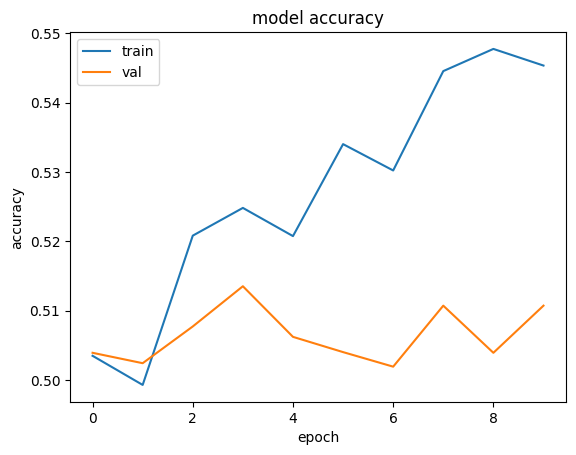

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

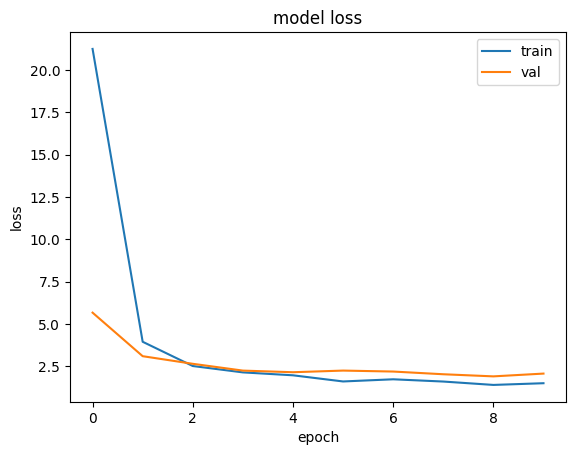

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## 2.2 Model with Tokenization and Embeddings

Now we add an embedding layer to our model.

In [ ]:
max_num_words = 32 * 10**3
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_num_words,
 output_mode='int',
 output_sequence_length=10)

vector_size = 16
embedding_layer = tf.keras.layers.Embedding(max_num_words, vector_size)

vectorize_layer.adapt(text_dataset)

model = tf.keras.models.Sequential([])
model.add(vectorize_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.GlobalAveragePooling1D(),)

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 10s 224ms/step - loss: 0.6902 - accuracy: 0.5380 - val_loss: 0.6817 - val_accuracy: 0.5790
Epoch 2/10
30/30 [==============================] - 6s 203ms/step - loss: 0.6398 - accuracy: 0.6440 - val_loss: 0.6383 - val_accuracy: 0.6364
Epoch 3/10
30/30 [==============================] - 4s 105ms/step - loss: 0.5606 - accuracy: 0.7078 - val_loss: 0.6208 - val_accuracy: 0.6532
Epoch 4/10
30/30 [==============================] - 3s 93ms/step - loss: 0.5203 - accuracy: 0.7348 - val_loss: 0.6346 - val_accuracy: 0.6518
Epoch 5/10
30/30 [==============================] - 3s 88ms/step - loss: 0.5005 - accuracy: 0.7482 - val_loss: 0.6475 - val_accuracy: 0.6528
Epoch 6/10
30/30 [==============================] - 4s 128ms/step - loss: 0.4894 - accuracy: 0.7507 - val_loss: 0.6617 - val_accuracy: 0.6506
Epoch 7/10
30/30 [==============================] - 3s 93ms/step - loss: 0.4858 - accuracy: 0.7563 - val_loss: 0.6699 - val_accuracy: 0.6465
Epoch 8/

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 10)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 10, 16)            512000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_4 (Dense)             (None, 256)               4352      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)               

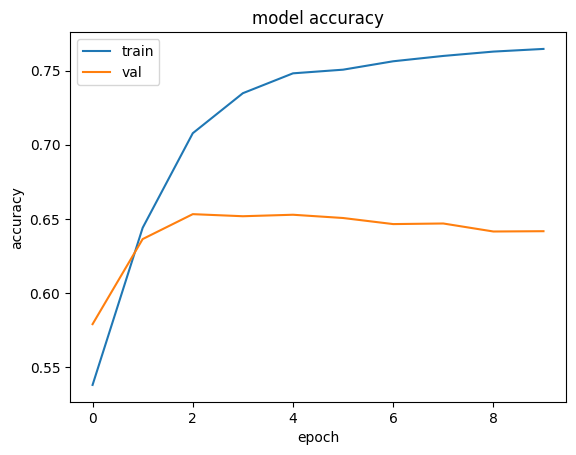

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

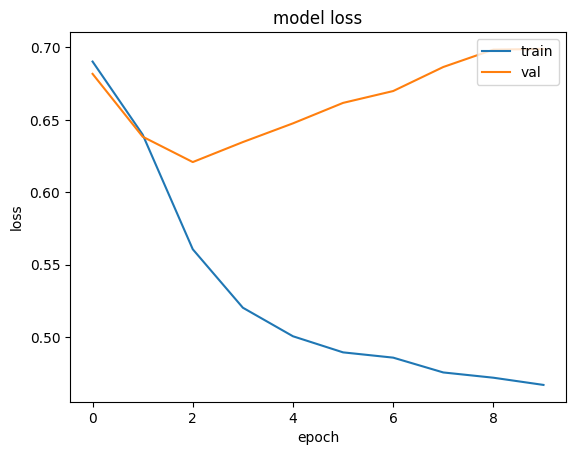

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## 2.3 Model with Pre-trained Embeddings

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)


model = tf.keras.models.Sequential([])
model.add(hub_layer)

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_8 (Dense)             (None, 256)               13056     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 48244873 (184.04 MB)
Trainable params: 48244873 (184.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 9s 236ms/step - loss: 0.5568 - accuracy: 0.7300 - val_loss: 0.4629 - val_accuracy: 0.7849
Epoch 2/10
30/30 [==============================] - 6s 195ms/step - loss: 0.3504 - accuracy: 0.8473 - val_loss: 0.3545 - val_accuracy: 0.8508
Epoch 3/10
30/30 [==============================] - 6s 201ms/step - loss: 0.2080 - accuracy: 0.9231 - val_loss: 0.3448 - val_accuracy: 0.8621
Epoch 4/10
30/30 [==============================] - 6s 195ms/step - loss: 0.1106 - accuracy: 0.9653 - val_loss: 0.3862 - val_accuracy: 0.8645
Epoch 5/10
30/30 [==============================] - 6s 193ms/step - loss: 0.0471 - accuracy: 0.9887 - val_loss: 0.4697 - val_accuracy: 0.8610
Epoch 6/10
30/30 [==============================] - 6s 209ms/step - loss: 0.0180 - accuracy: 0.9968 - val_loss: 0.5547 - val_accuracy: 0.8628
Epoch 7/10
30/30 [==============================] - 6s 199ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.6277 - val_accuracy: 0.8617
Epoch 8/10
30/30 

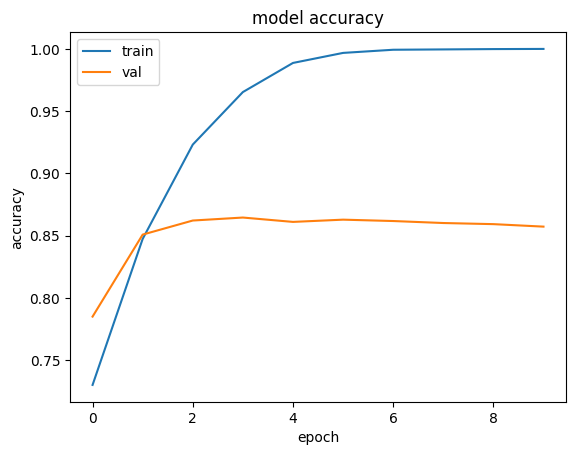

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

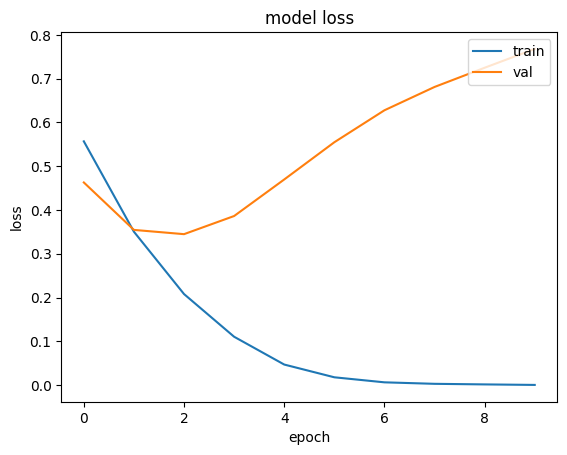

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## 2.4 RNN's with the LSTM Layer

RNN's (Recurrent Neural Networks) are a type of network that can take sequences as input and remember prior parts of the sequence when making predictions.

LSTM layers are a type of recurrent layer that addresses the vanishing gradient problem and allows better memory from prior states.

![](https://miro.medium.com/v2/resize:fit:674/1*jikKbzFXCq-IYnFZankIMg.png)


In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)


model = tf.keras.models.Sequential([])
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((50, 1)))
model.add(tf.keras.layers.LSTM(16))

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 reshape_1 (Reshape)         (None, 50, 1)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 48192041 (183.84 MB)
Trainable params: 48192041 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 9s 216ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6916 - val_accuracy: 0.5512
Epoch 2/10
30/30 [==============================] - 6s 193ms/step - loss: 0.6879 - accuracy: 0.5925 - val_loss: 0.6812 - val_accuracy: 0.6426
Epoch 3/10
30/30 [==============================] - 6s 205ms/step - loss: 0.6622 - accuracy: 0.6781 - val_loss: 0.6318 - val_accuracy: 0.7070
Epoch 4/10
30/30 [==============================] - 6s 195ms/step - loss: 0.5489 - accuracy: 0.7720 - val_loss: 0.4957 - val_accuracy: 0.7904
Epoch 5/10
30/30 [==============================] - 6s 205ms/step - loss: 0.4011 - accuracy: 0.8538 - val_loss: 0.4377 - val_accuracy: 0.8236
Epoch 6/10
30/30 [==============================] - 5s 159ms/step - loss: 0.2919 - accuracy: 0.9005 - val_loss: 0.4013 - val_accuracy: 0.8293
Epoch 7/10
30/30 [==============================] - 6s 197ms/step - loss: 0.2149 - accuracy: 0.9330 - val_loss: 0.4094 - val_accuracy: 0.8427
Epoch 

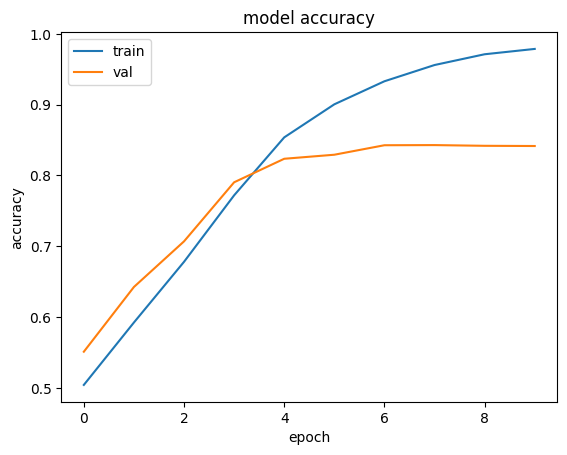

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

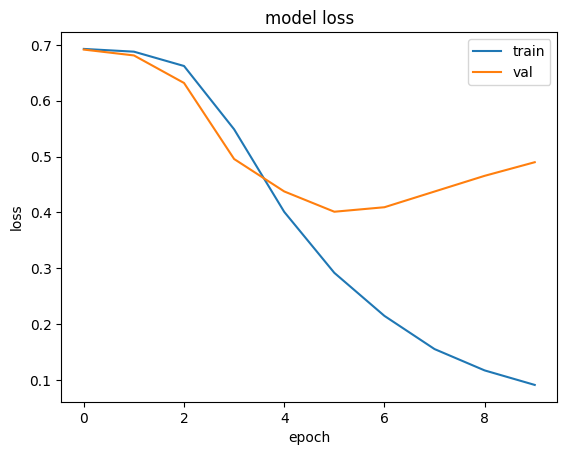

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## 2.5 Bi-directional LSTM's

Bi-directional LSTMs allow information to propagate both forwards and backwards to improve performance.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)


model = tf.keras.models.Sequential([])
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((50, 1)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 50)                48190600  
                                                                 
 reshape_2 (Reshape)         (None, 50, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 50, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 32)            10368     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 8)                

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 16s 280ms/step - loss: 0.6776 - accuracy: 0.6296 - val_loss: 0.6324 - val_accuracy: 0.6945
Epoch 2/10
30/30 [==============================] - 6s 183ms/step - loss: 0.5371 - accuracy: 0.7417 - val_loss: 0.4750 - val_accuracy: 0.7739
Epoch 3/10
30/30 [==============================] - 7s 218ms/step - loss: 0.3657 - accuracy: 0.8377 - val_loss: 0.4010 - val_accuracy: 0.8190
Epoch 4/10
30/30 [==============================] - 8s 260ms/step - loss: 0.2527 - accuracy: 0.8991 - val_loss: 0.3866 - val_accuracy: 0.8404
Epoch 5/10
30/30 [==============================] - 6s 195ms/step - loss: 0.1735 - accuracy: 0.9369 - val_loss: 0.4058 - val_accuracy: 0.8455
Epoch 6/10
30/30 [==============================] - 5s 176ms/step - loss: 0.1111 - accuracy: 0.9641 - val_loss: 0.4692 - val_accuracy: 0.8467
Epoch 7/10
30/30 [==============================] - 6s 176ms/step - loss: 0.0623 - accuracy: 0.9831 - val_loss: 0.5583 - val_accuracy: 0.8444
Epoch

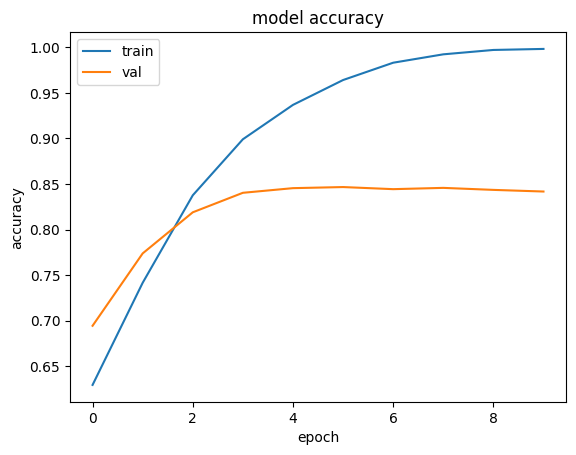

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

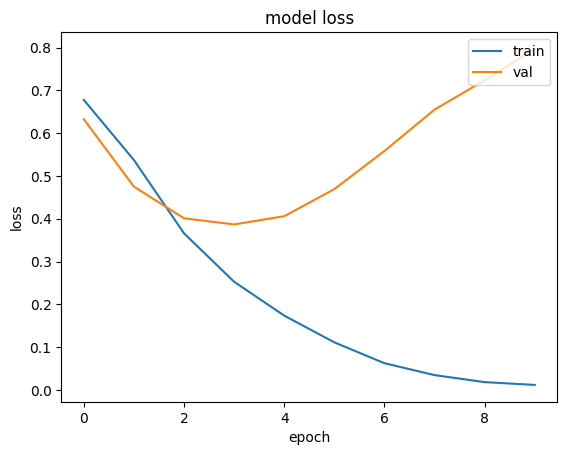

In [ ]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
max_num_words = 32 * 10**3
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_num_words,
 output_mode='int',
 output_sequence_length=10)

vector_size = 50
embedding_layer = tf.keras.layers.Embedding(max_num_words, vector_size)

vectorize_layer.adapt(text_dataset)

model = tf.keras.models.Sequential([])
model.add(vectorize_layer)
model.add(embedding_layer)
model.add(tf.keras.layers.LSTM(16))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)